# Cardio Catch Disease

## LIBRARIES AND SETTINGS

In [100]:
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import seaborn               as sns

from sklearn.metrics         import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.preprocessing   import MinMaxScaler
from scipy.stats             import chi2_contingency
from IPython.display         import Image
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.linear_model    import Perceptron
from sklearn.neural_network  import MLPClassifier

In [2]:
# graphics style
sns.set_style('darkgrid')

## FUNCTIONS

In [104]:
# configure the axes of the chart
def axis_settings(x_label, y_label = ' ', fontsize = 12, x_rotation = 0, y_rotation = 0):
    plt.xlabel(x_label, fontsize = fontsize)
    plt.ylabel(y_label, fontsize = fontsize)
    plt.xticks(fontsize = fontsize, rotation = x_rotation)
    plt.yticks(fontsize = fontsize, rotation = y_rotation)
    

# Chi-square test of independence
def chi_squared(data, variable1, variable2):
    # contingency table
    contigency = pd.crosstab(data[variable1], data[variable2])

    # Chi-square test of independence
    c, p, dof, expected = chi2_contingency(contigency)

    if p > 0.05:
        print("H0 is accepted: the variables don't have a significant relationship.")
    else:
        print('H0 is rejected: the variables have a significant relationship.')
        
    return p


# cross validation
def cross_validation(model, model_name, cv, x, y):
    score = cross_validate(model, x, y, cv = cv, scoring = ('accuracy', 'precision', 'recall', 'f1'))
    
    return pd.DataFrame({'Model': model_name,
                         'Accuracy': np.round(score['test_accuracy'].mean(), 3).astype(str) + ' +/- ' + np.round(score['test_accuracy'].std(), 3).astype(str), 
                         'Precision': np.round(score['test_precision'].mean(), 3).astype(str) + ' +/- ' + np.round(score['test_precision'].std(), 3).astype(str), 
                         'Recall': np.round(score['test_recall'].mean(), 3).astype(str) + ' +/- ' + np.round(score['test_recall'].std(), 3).astype(str), 
                         'F1 score': np.round(score['test_f1'].mean(), 3).astype(str) + ' +/- ' + np.round(score['test_f1'].std(), 3).astype(str)}, 
                         index = [0])

## 1. DATA LOADING

The dataset can be downloaded from this [link](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset).

In [4]:
# open the file
df = pd.read_csv('../data/cardio_train.csv', sep = ';')

## 2. DATA DESCRIPTION

### 2.1. Basic information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


**Observation:**
- There aren't missing values.

### 2.2. Statistic measures

In [6]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


### 2.3. Univariate analysis

#### 2.3.1. Cardio distribution

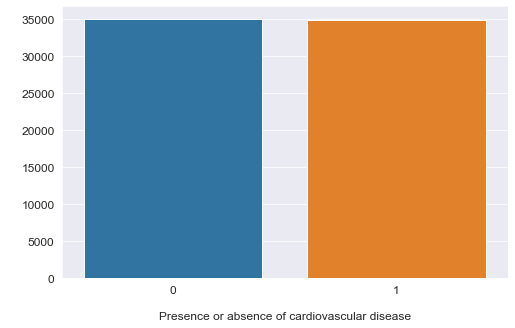

In [7]:
plt.figure(figsize = (8, 5))
sns.countplot(data = df, x = 'cardio')
axis_settings('\nPresence or absence of cardiovascular disease')
plt.show()

**Observation:**
- The number of records of each class is practically the same, that is, the data set is balanced.

#### 2.3.2. Age distribution

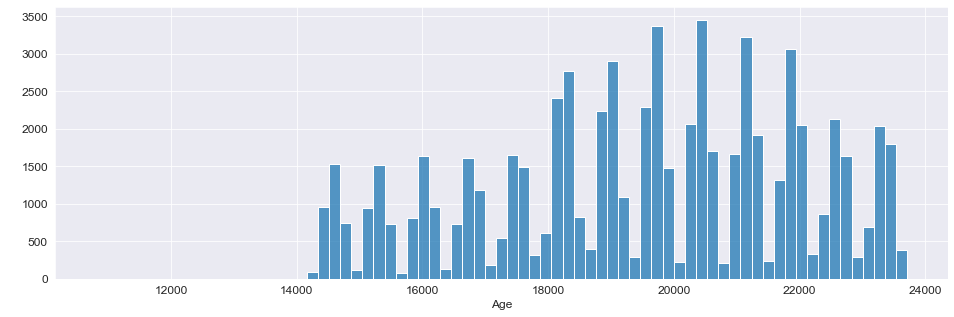

In [8]:
plt.figure(figsize = (16, 5))
sns.histplot(data = df, x = 'age')
axis_settings('Age')
plt.show()

**Observation:**
- The `age` attribute is represented in days. So it is necessary to change to years, to be easier to manipulate this variable.

#### 2.3.3. Gender distribution

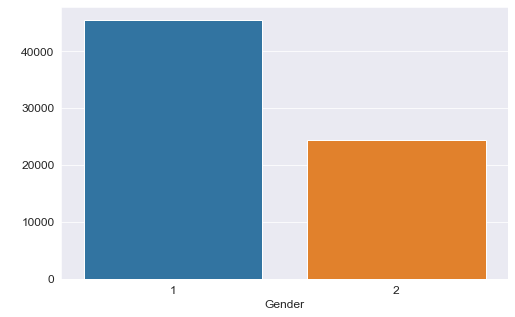

In [9]:
plt.figure(figsize = (8, 5))
sns.countplot(data = df, x = 'gender')
axis_settings('Gender')
plt.show()

**Observation:**
- 1 represents women and 2 represents men;
- There more women than men in this database. The explanation for this may be the fact that women tend to go to the doctor more often than men.

#### 2.3.4. Height distribution

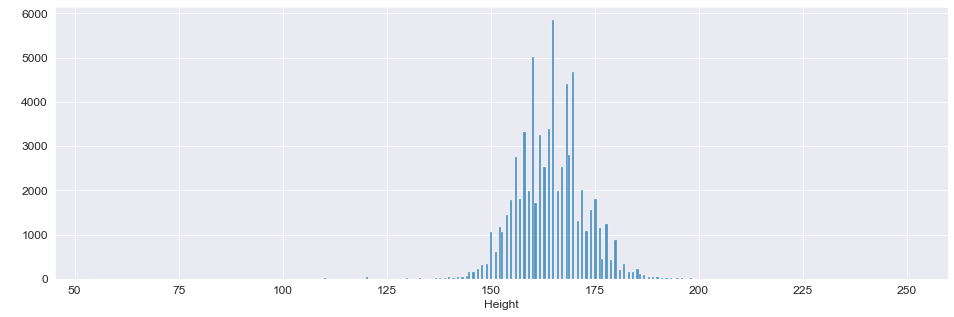

In [10]:
plt.figure(figsize = (16, 5))
sns.histplot(data = df, x = 'height')
axis_settings('Height')
plt.show()

**Observation:**
- Height is in centimeters;
- Most patients are between 150cm and 175cm tall.

#### 2.3.5. Weight distribution

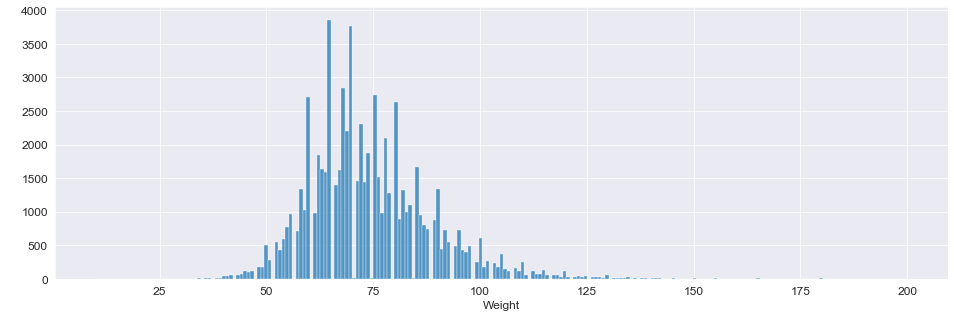

In [11]:
plt.figure(figsize = (16, 5))
sns.histplot(data = df, x = 'weight')
axis_settings('Weight')
plt.show()

**Observation:**
- Weight is in kilograms;
- Most patients are between 50Kg and 100Kg.

#### 2.3.6. Blood pressure distribution

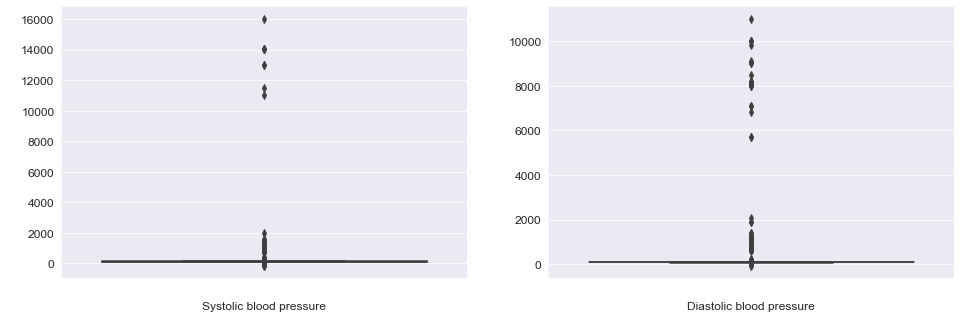

In [12]:
plt.figure(figsize = (16, 5))

# graphic 1
plt.subplot(1, 2, 1)
sns.boxplot(data = df, y = 'ap_hi')
axis_settings('\nSystolic blood pressure')

# graphic 2
plt.subplot(1, 2, 2)
sns.boxplot(data = df, y = 'ap_lo')
axis_settings('\nDiastolic blood pressure')

plt.show()

**Observation:**
- Most patients are between systolic and diastolic blood pressure at normal levels, but at values that are very high and must be treated later.

#### 2.3.7. Cholesterol and glucose distribution

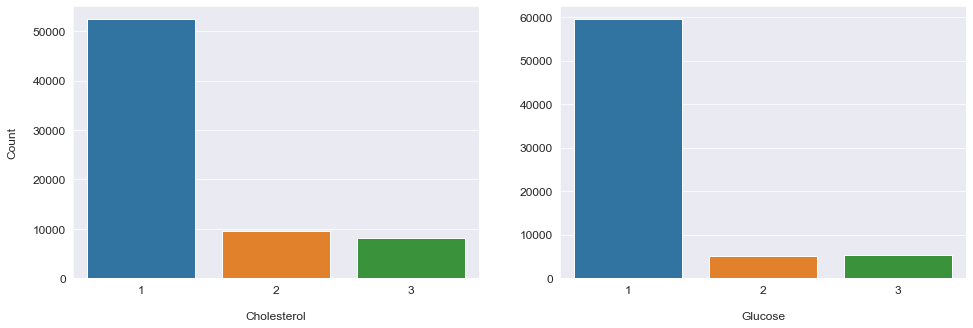

In [13]:
plt.figure(figsize = (16, 5))

# graphic 1
plt.subplot(1, 2, 1)
sns.countplot(data = df, x = 'cholesterol')
axis_settings('\nCholesterol', 'Count\n')

# graphic 2
plt.subplot(1, 2, 2)
sns.countplot(data = df, x = 'gluc')
axis_settings('\nGlucose')

plt.show()

**Observation:**
- The two graphs show that most patients have normal cholesterol and glucose levels.

#### 2.3.8. Smoke, alcohol intake and physical activity distribution

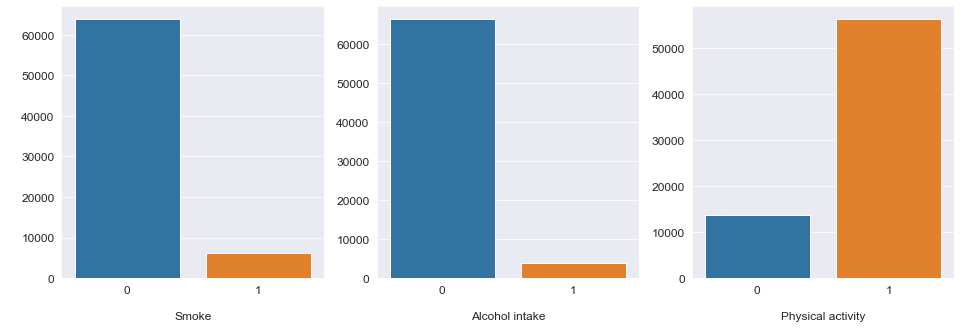

In [14]:
plt.figure(figsize = (16, 5))

# graphic 1
plt.subplot(1, 3, 1)
sns.countplot(data = df, x = 'smoke')
axis_settings('\nSmoke')

# graphic 2
plt.subplot(1, 3, 2)
sns.countplot(data = df, x = 'alco')
axis_settings('\nAlcohol intake')

# graphic 3
plt.subplot(1, 3, 3)
sns.countplot(data = df, x = 'active')
axis_settings('\nPhysical activity')

plt.show()

**Observation:**
- In the first two graphs, it is possible to notice that most patients do not smoke or drink alcohol;
- The third graph shows that most patients do physical exercises regularly.

## 3. DATA CLEANING

In [15]:
# age (day -> year)
df['age'] = df['age'] / 365

# change data type (float -> int)
df['age'] = df['age'].astype(int)

# gender (female: 1 -> 0, male: 2 -> 1)
df['gender'] = df['gender'].apply(lambda x: 0 if x == 1 else 1)

# height (cm -> m)
df['height'] = df['height'] / 100

# remove rows whose height variable is less than 1m or greater than 2.3m
df.drop(df[(df['height'] < 1) & (df['height'] == 2.5)].index, inplace = True)

# remove lines whose weight variable is less than 30Kg
df.drop(df[df['weight'] < 30].index, inplace = True)

# removes lines whose diastolic pressure (ap_lo) is greater than or equal to systolic pressure (ap_hi)
df.drop(df[df['ap_lo'] >= df['ap_hi']].index, inplace = True)

# removes rows whose systolic blood pressure (ap_hi) is less than 40mmHg or greater than 200mmHg
df.drop(df[(df['ap_hi'] < 40) | (df['ap_hi'] > 200)].index, inplace = True)

# removes rows whose diastolic blood pressure (ap_hi) is less than 40mmHg or greater than 140mmHg
df.drop(df[(df['ap_lo'] < 40) | (df['ap_lo'] > 140)].index, inplace = True)

# reset index
df.reset_index(drop = True, inplace = True)

## 4. FEATURE ENGINEERING

### 4.1. Body Mass Index (BMI)

The table below shows the values of each BMI classification according to the World Health Organization (WHO).

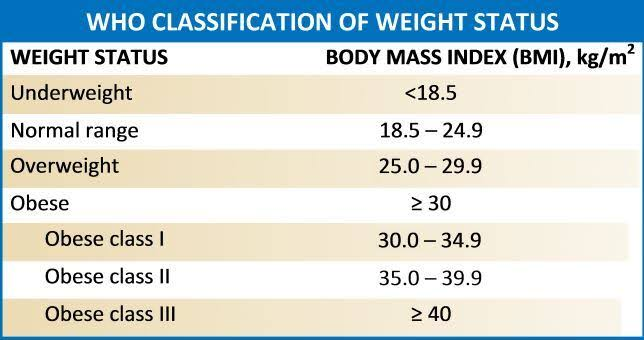

In [16]:
Image('../images/bmi.jpeg', width = 500, height = 50)

In [17]:
# bmi values
df['bmi'] = df['weight'] / (df['height'] * df['height'])

In [18]:
# bmi classification
df['bmi_status'] = df['bmi'].apply(lambda x: 'underweight' if x < 18.5 else 
                                             'normal' if (x >= 18.5) & (x < 25) else
                                             'overweight' if (x >= 25) & (x < 30) else
                                             'obese')

### 4.2. Blood pressure

The chart below shows the values for each blood pressure category according to the American Heart Association (AHA).

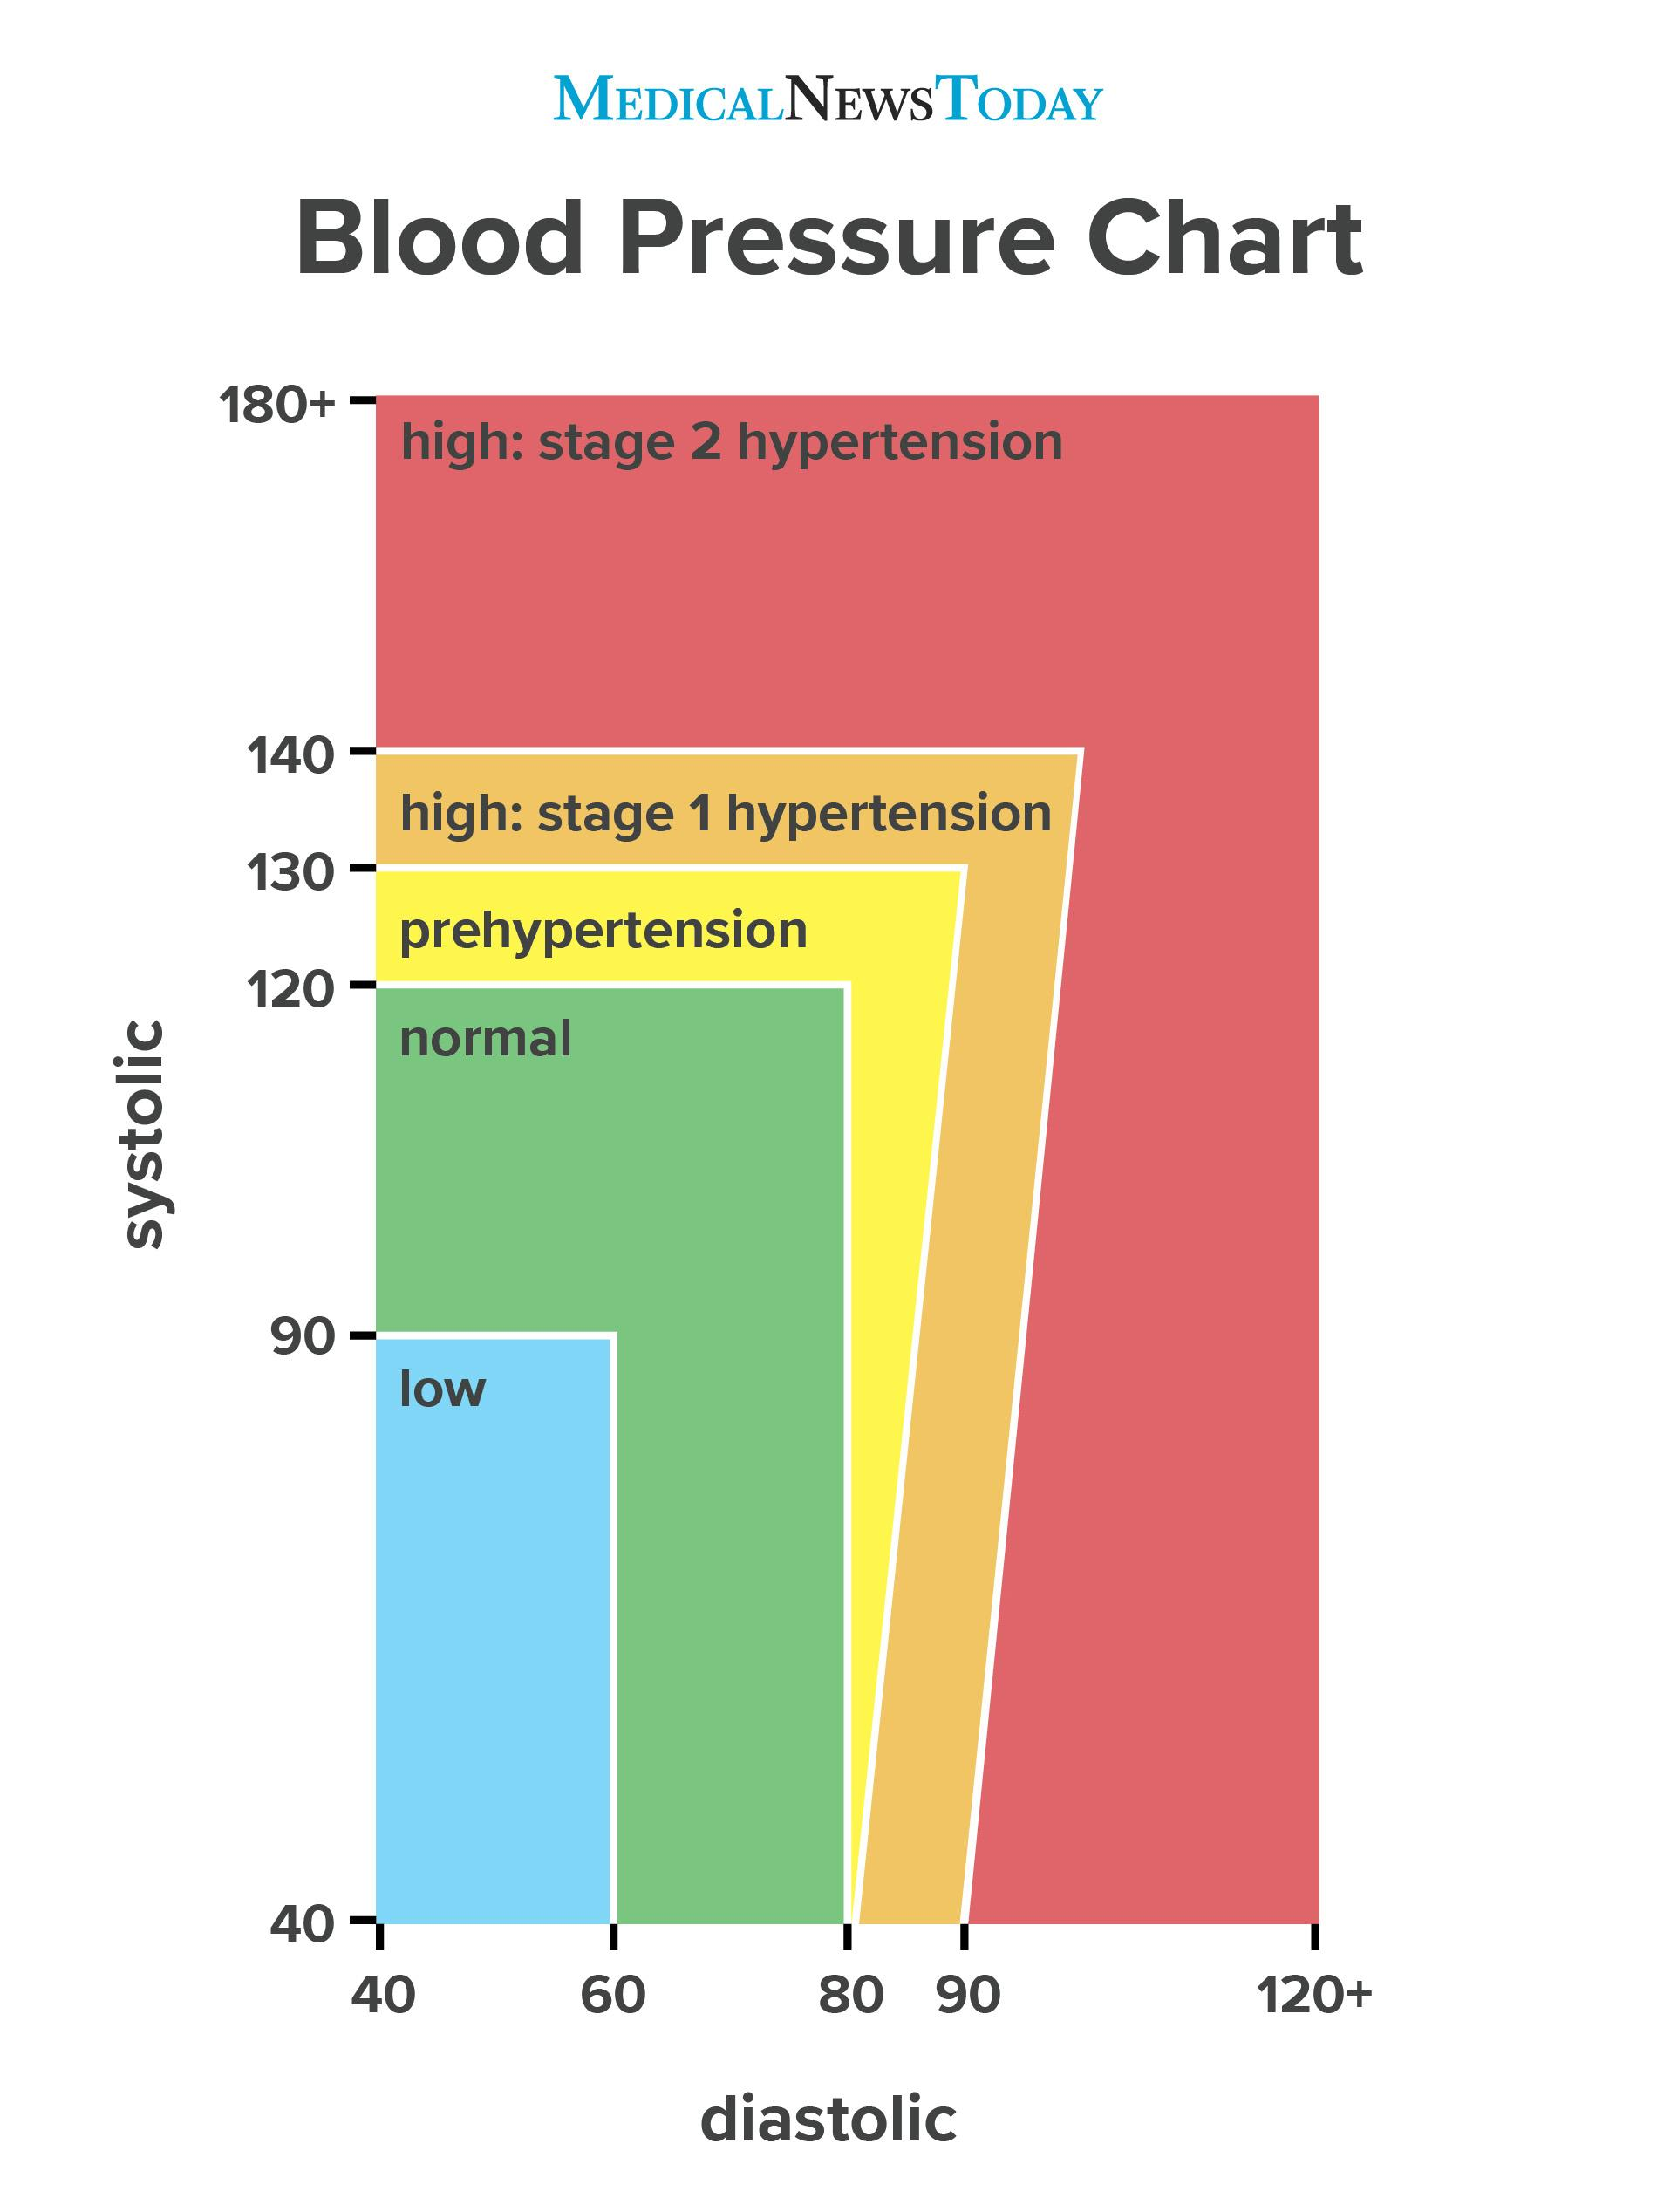

In [19]:
Image('../images/a-blood-pressure-chart-infographic.jpg', width = 400, height = 800)

In [20]:
# blood pressure categories
for i in range(len(df)):
    if (df.loc[i, 'ap_hi'] <= 90) & (df.loc[i, 'ap_lo'] <= 60):
        df.loc[i, 'blood_pressure'] = 'low'
    elif (df.loc[i, 'ap_hi'] <= 120) & (df.loc[i, 'ap_lo'] <= 80):
        df.loc[i, 'blood_pressure'] = 'normal'
    elif (df.loc[i, 'ap_hi'] <= 130) & (df.loc[i, 'ap_lo'] <= 80):
        df.loc[i, 'blood_pressure'] = 'prehypertension'
    elif (df.loc[i, 'ap_hi'] <= 140) & (df.loc[i, 'ap_lo'] <= 90):
        df.loc[i, 'blood_pressure'] = 'hypertension 1'
    elif (df.loc[i, 'ap_hi'] <= 220) & (df.loc[i, 'ap_lo'] <= 140):
        df.loc[i, 'blood_pressure'] = 'hypertension 2'

## 5. EXPLORATORY DATA ANALYSIS

### 5.1. Hypothesis mind map

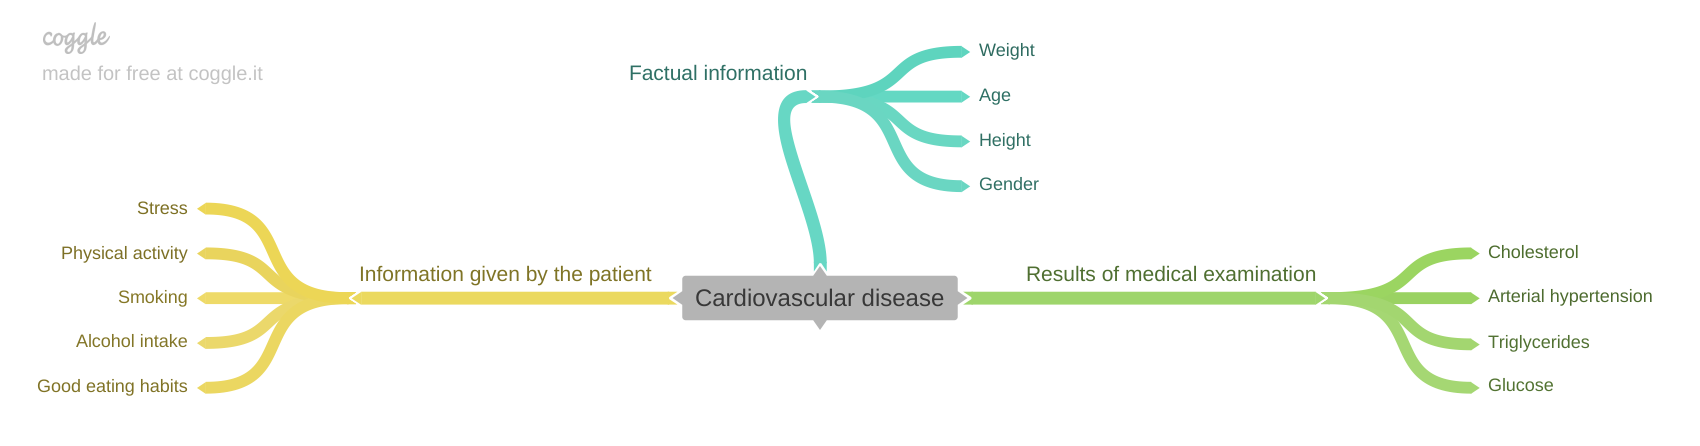

In [21]:
Image('../images/hypothesis.png')

### 5.2 Hypothesis

#### 5.2.1. People over the age of 50 have are more susceptible to cardiovascular disease.
This hypothesis is **True**.

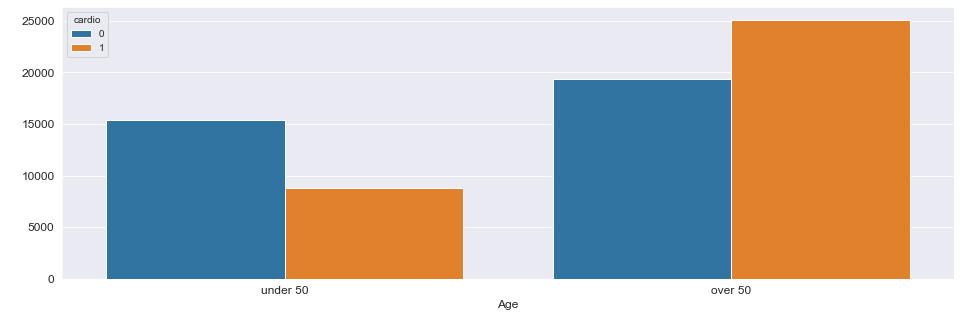

In [22]:
# classifies ages as over 50 and under 50
df['age50'] = df['age'].apply(lambda x: 'over 50' if x > 50 else 'under 50')

# graph
plt.figure(figsize = (16, 5))
sns.countplot(data = df, x = 'age50', hue = 'cardio')
axis_settings('Age')
plt.show()

#### 5.2.2. Obese people are more susceptible to cardiovascular disease.
This hypothesis is **True**.

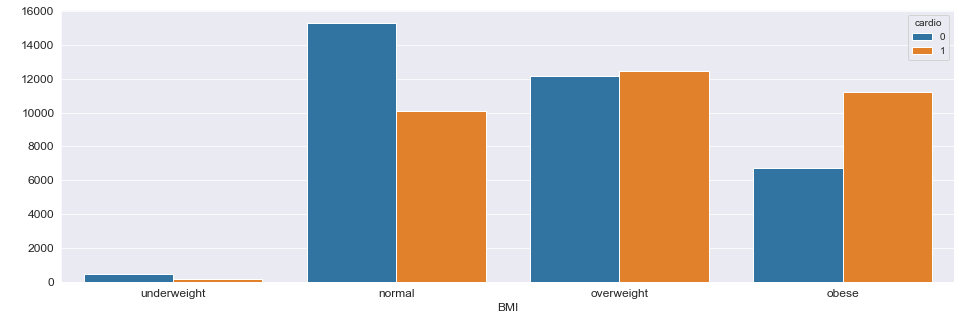

In [23]:
# graph
plt.figure(figsize = (16, 5))
sns.countplot(data = df, x = 'bmi_status', hue = 'cardio', order = ['underweight', 'normal', 'overweight', 'obese'])
axis_settings('BMI')
plt.show()

#### 5.2.3. Gender influences a person's risk of cardiovascular disease.
This hypothesis is **False**.

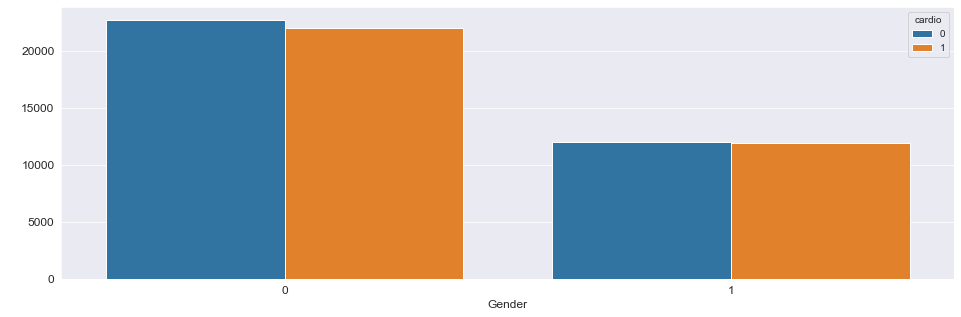

In [24]:
# graph
plt.figure(figsize = (16, 5))
sns.countplot(data = df, x = 'gender', hue = 'cardio')
axis_settings('Gender')
plt.show()

In [25]:
# Chi-square test of independence
chi_squared(df, 'gender', 'cardio')

H0 is accepted: the variables don't have a significant relationship.


0.07243881811975973

#### 5.2.4. People with high cholesterol are more susceptible to cardiovascular disease.
This hypothesis is **True**.

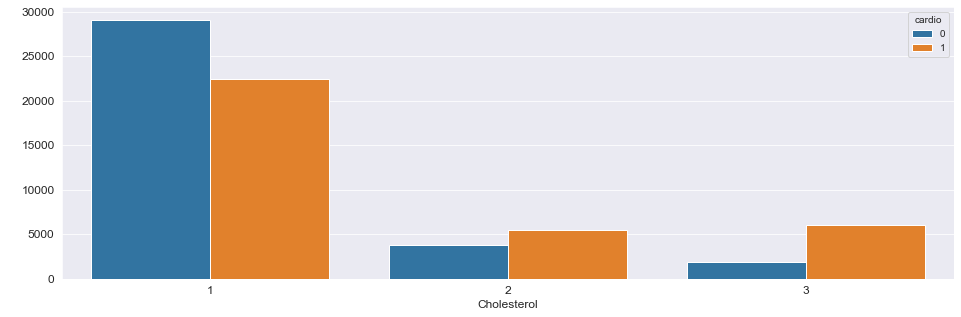

In [26]:
# graph
plt.figure(figsize = (16, 5))
sns.countplot(data = df, x = 'cholesterol', hue = 'cardio')
axis_settings('Cholesterol')
plt.show()

In [27]:
# Chi-square test of independence
chi_squared(df, 'cholesterol', 'cardio')

H0 is rejected: the variables have a significant relationship.


0.0

Classes 1, 2 and 3 means normal, above normal and well above normal, respectively.

#### 5.2.5. People with high glucose are more susceptible to cardiovascular disease.
This hypothesis is **True**.

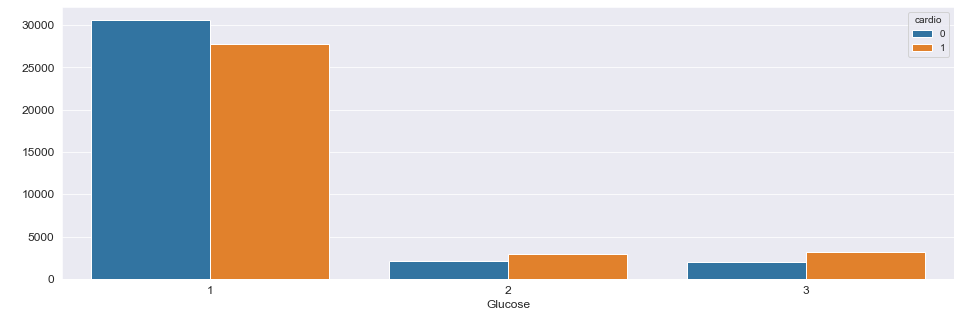

In [28]:
# graph
plt.figure(figsize = (16, 5))
sns.countplot(data = df, x = 'gluc', hue = 'cardio')
axis_settings('Glucose')
plt.show()

In [29]:
# Chi-square test of independence
chi_squared(df, 'gluc', 'cardio')

H0 is rejected: the variables have a significant relationship.


4.734860778133936e-126

Classes 1, 2 and 3 means normal, above normal and well above normal, respectively.

#### 5.2.6. People with hypertension are more susceptible to cardiovascular disease.
This hypothesis is **True**.

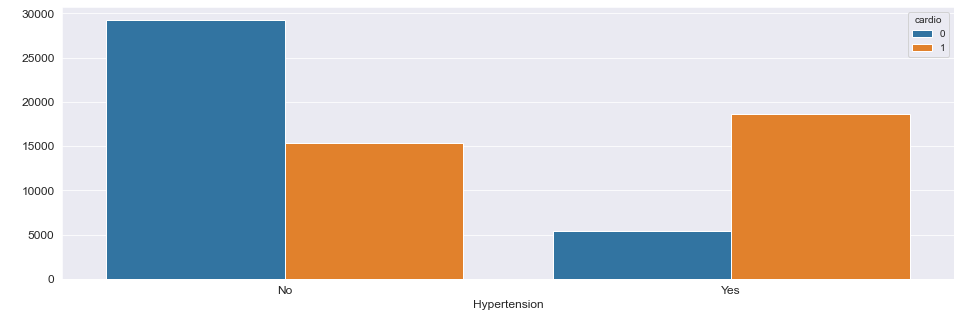

In [30]:
# classifies if a person has hypertension
df['hypertension'] = df['blood_pressure'].apply(lambda x: 'Yes' if (x == 'hypertension 1') | (x == 'hypertension 2') else 
                                                          'No')

# graph
plt.figure(figsize = (16, 5))
sns.countplot(data = df, x = 'hypertension', hue = 'cardio')
axis_settings('Hypertension')
plt.show()

In [31]:
# Chi-square test of independence
chi_squared(df, 'hypertension', 'cardio')

H0 is rejected: the variables have a significant relationship.


0.0

#### 5.2.7. People with hypotension are more susceptible to cardiovascular disease.
This hypothesis is **False**.

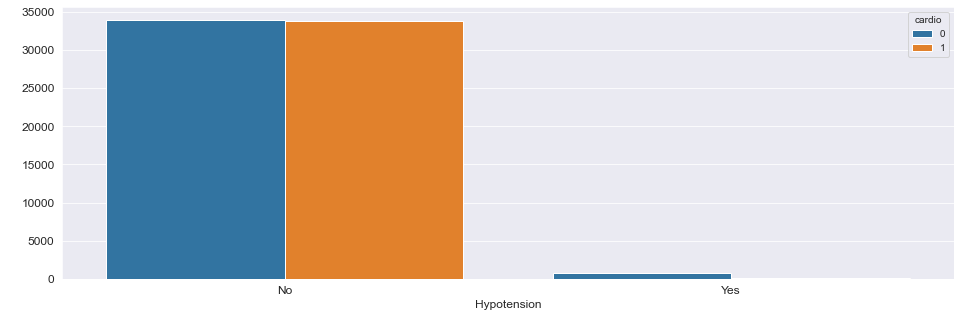

In [32]:
# classifies if a person has hypotension
df['hypotension'] = df['blood_pressure'].apply(lambda x: 'Yes' if (x == 'low') else 'No')

# graph
plt.figure(figsize = (16, 5))
sns.countplot(data = df, x = 'hypotension', hue = 'cardio')
axis_settings('Hypotension')
plt.show()

In [33]:
# Chi-square test of independence
chi_squared(df, 'hypotension', 'cardio')

H0 is rejected: the variables have a significant relationship.


2.1549291797931703e-88

In [34]:
pd.crosstab(index = df['hypotension'], columns = df['cardio'], normalize = True)

cardio,0,1
hypotension,,
No,0.494979,0.492501
Yes,0.010567,0.001953


#### 5.2.8. The habit of smoking makes people more susceptible to cardiovascular disease.
This hypothesis is **False**.

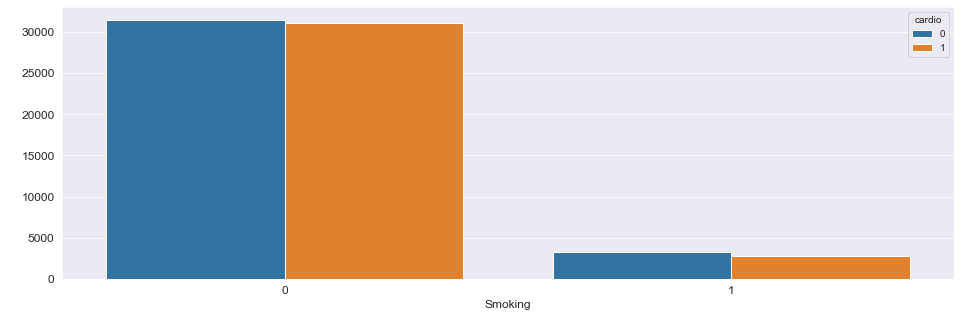

In [35]:
# graph
plt.figure(figsize = (16, 5))
sns.countplot(data = df, x = 'smoke', hue = 'cardio')
axis_settings('Smoking')
plt.show()

In [36]:
# Chi-square test of independence
chi_squared(df, 'smoke', 'cardio')

H0 is rejected: the variables have a significant relationship.


1.804123003836953e-05

#### 5.2.9. The habit of ingesting alcohol makes people more susceptible to cardiovascular diseases.
This hypothesis is **False**.

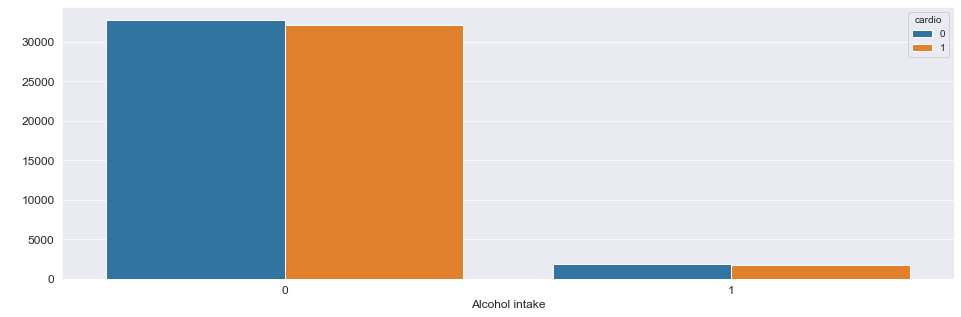

In [37]:
# graph
plt.figure(figsize = (16, 5))
sns.countplot(data = df, x = 'alco', hue = 'cardio')
axis_settings('Alcohol intake')
plt.show()

In [38]:
# Chi-square test of independence
chi_squared(df, 'alco', 'cardio')

H0 is rejected: the variables have a significant relationship.


0.021392677224986497

#### 5.2.10. Sedentary people tend to be more susceptible to cardiovascular disease.
This hypothesis is **True**.

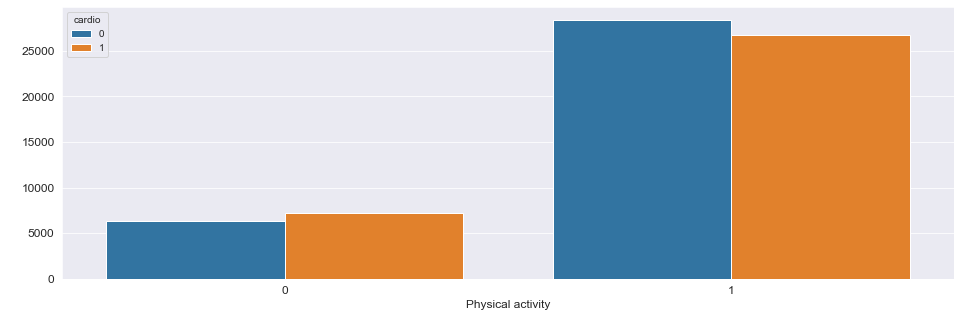

In [39]:
# graph
plt.figure(figsize = (16, 5))
sns.countplot(data = df, x = 'active', hue = 'cardio')
axis_settings('Physical activity')
plt.show()

In [40]:
# Chi-square test of independence
chi_squared(df, 'active', 'cardio')

H0 is rejected: the variables have a significant relationship.


1.1893190642252079e-22

### 5.3. Correlation between the variables

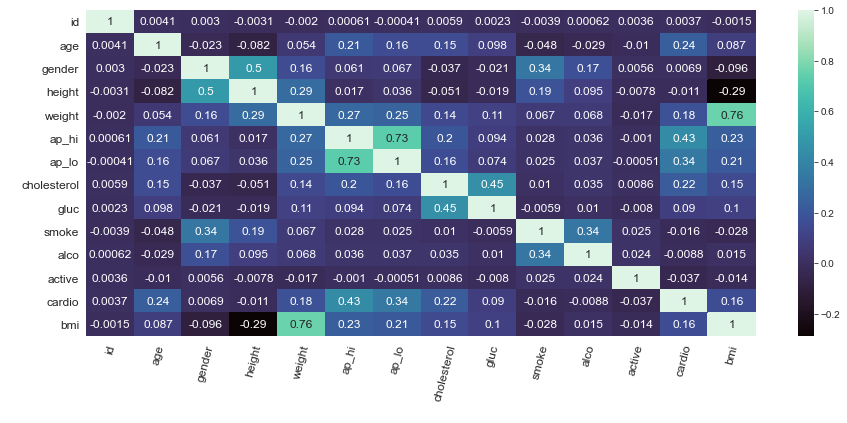

In [41]:
plt.figure(figsize = (15, 6))
sns.heatmap(df.corr(), annot = True, cmap = 'mako', annot_kws = {'size': 12})
axis_settings(' ', x_rotation = 75)

## 6. FEATURE SELECTION

In [42]:
# select relevant features
df_selected = df[['age', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi', 'cardio']].copy()

## 7. DATA PREPARATION

### 7.1. Rescaling

In [43]:
# min max scaler
mms = MinMaxScaler()

# ap_hi
df_selected['ap_hi'] = mms.fit_transform(df_selected[['ap_hi']].values)

# ap_lo
df_selected['ap_lo'] = mms.fit_transform(df_selected[['ap_lo']].values)

# bmi
df_selected['bmi'] = mms.fit_transform(df_selected[['bmi']].values)

# age
df_selected['age'] = mms.fit_transform(df_selected[['age']].values)

### 7.2. Splits the dataframe into training and test dataset

In [44]:
# x and y
x = df_selected.drop('cardio', axis = 1)
y = df_selected['cardio']

# train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

## 8. MODEL BUILDING

### 8.1. k-Nearest Neighbors

In [105]:
knn = cross_validation(KNeighborsClassifier(), 'KNN', 5, x_train, y_train)
knn

,Model,Accuracy,Precision,Recall,F1 score
0,KNN,0.697 +/- 0.002,0.697 +/- 0.003,0.682 +/- 0.008,0.69 +/- 0.004


### 8.2. Decision Tree 

In [106]:
dtree = cross_validation(DecisionTreeClassifier(), 'Decision tree', 5, x_train, y_train)
dtree

,Model,Accuracy,Precision,Recall,F1 score
0,Decision tree,0.637 +/- 0.004,0.635 +/- 0.004,0.624 +/- 0.005,0.629 +/- 0.004


### 8.3. Perceptron

In [107]:
pcp = cross_validation(Perceptron(), 'Perceptron', 5, x_train, y_train)
pcp

,Model,Accuracy,Precision,Recall,F1 score
0,Perceptron,0.609 +/- 0.06,0.619 +/- 0.104,0.782 +/- 0.216,0.656 +/- 0.04


### 8.4. Multi-layer Perceptron 

In [108]:
mlp = cross_validation(MLPClassifier(), 'MLP', 5, x_train, y_train)
mlp

C:\Users\Usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,Accuracy,Precision,Recall,F1 score
0,MLP,0.734 +/- 0.003,0.75 +/- 0.011,0.693 +/- 0.021,0.72 +/- 0.007


### 8.5. Logistc Regression 

### 8.6. Support Vectors Machine

### 8.7. Random Forest

### 8.8. Naive Bayes

### 8.9. XGBoost Classifier

### 8.10. LGBM Classifier

### 8.11. Comparison between models

In [111]:
results = pd.concat([knn, dtree, pcp, mlp])
results

,Model,Accuracy,Precision,Recall,F1 score
0,KNN,0.697 +/- 0.002,0.697 +/- 0.003,0.682 +/- 0.008,0.69 +/- 0.004
0,Decision tree,0.637 +/- 0.004,0.635 +/- 0.004,0.624 +/- 0.005,0.629 +/- 0.004
0,Perceptron,0.609 +/- 0.06,0.619 +/- 0.104,0.782 +/- 0.216,0.656 +/- 0.04
0,MLP,0.734 +/- 0.003,0.75 +/- 0.011,0.693 +/- 0.021,0.72 +/- 0.007


## 9. TRANSLATION AND INTERPRETATION OF ERROR